In [1]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
import re
import pdfplumber
import unicodedata
from IPython.display import Markdown, display
%load_ext jupyter_tikz

assesment_draw_and_fill = True

**Disclaimer:** This notebook pretends to be didactic, introducing the ideas behind the concepts used to train neural probabilistic language models. This means that, modern models are implemented using advanced algorithms based on these ideas. Also, the RNN is overfitted otherwise with few data we do not get any cool response.

# Recurrent Neural Network Language Model with Dense Input Embedding Matrix

So far so good, we have seen how to convert text to numerical representations in various ways. These representations could be used as features to train classifiers on tasks such as, for example, detect racism in a text. 

We will see that, in the process of training such models, we will introduce a new concept for embedding. The task we train our model on will bias this embedding towards being good at representing different aspects of interest (semantic similarity, clustering, discrimination between two classes) and so on.

One of such tasks we can implement is Language generation, where the goal is to generate text based on the already generated one. In this assesment we will implement the Recurrent Nueral Network Language Model from Mikolov `https://www.fit.vut.cz/research/group/speech/public/publi/2010/mikolov_interspeech2010_IS100722.pdf` but instead of using a one hot encoding embedding representation of the words, we will use a dense embedding representation, such as the one we learn in the CBOW model.

This means that the input to the model instead of being a one-hot encoding vector will be a dense vector obtained from an embedding matrix. There are plenty choices for this embedding matrix:

* Use the one obtained by learning first the CBOW or Skip-Gram model.
* Learn and embedding matrix jointly with the model parameters itself. Note this embedding matrix will represent input words in a way that they are good representations for the task at hand.
* Start from the embedding matrix obtained by learning first the CBOW or Skip-Gram model, and then learn this embedding matrix jointly with the model parameters itself.

We will also see how the postprocessing step of Language modelling can be used within this task. Rememeber in language modeling the steps we perform are:

* normalization/preprocessing
* tokenization (pre-tokenization and training)
* modelling
* post processing

## A statistical model for Language Generation

Note that the objective of the CBOW model is just to learn good representations of words, based on the ideas that the words in the surroundings are relevant, and thus we try to find and learn this statistical relationships.

However, for language generation this is not valid, because if we want to generate a word at time $t$, this word only depends on what was generated in the past, since the future has not been generated yet. Thus, the way we frame this problem is to learn the probability of a word, given its context:

$$
p(w_t \mid w_{t-1},\dots,w_1)
$$

There are plenty of things here we need to consider. First of all, the model from the CBOW had a single matrix $A$, which might not be enough for representing this task. We can obviously gain expressiveness by making the model non-linear, and having a different matrix $A$ per word in the context. Forgetting about the computational complexity of doing this, the biggest problem is that since sentences in a language have different lengths, we'd have to restrict the context to a fix length in order to use a feedforward model such as the one used by the CBOW model. In other words, we'd only be able to learn:

$$
p(w_t \mid w_{t-1},\dots,w_{t-N})
$$

where $N$ is the context.

Since we do not want to restrict on this, we will use a recurrent neural network, which deals with arbitrary input sequence lenghts.

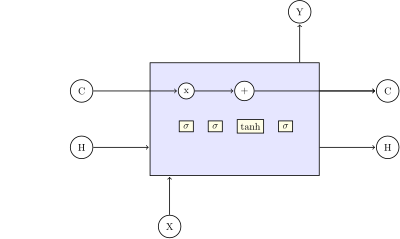

In [2]:
%%tikz


\usetikzlibrary{shapes.geometric, arrows, positioning}



\begin{tikzpicture}[shorten >=1pt, node distance=2cm, auto, thick]

% Estilos de nodos
\tikzstyle{block} = [rectangle, draw=black, fill=blue!10, minimum height=4cm, minimum width=6cm, text centered]
\tikzstyle{small_block} = [rectangle, draw=black, fill=yellow!10, minimum height=0.25cm, minimum width=0.5cm, text centered]
\tikzstyle{circle_node} = [circle, draw=black, fill=white, minimum size=0.8cm, text centered]
\tikzstyle{small_circle} = [circle, draw=black, fill=white, minimum size=0.4cm, text centered]

% Nodo de la celda LSTM (rectángulo horizontal)
\node[block] (lstm) {};

% Entradas (en círculos)
\node[circle_node, left=2cm of lstm, yshift=-1cm] (H_in) {H}; 
\node[circle_node, left=2cm of lstm, yshift=1cm] (C_in) {C};    
\node[circle_node, below left=1.5cm and -1cm of lstm] (X_in) {X}; % X en su posición original

% Salidas (en círculos)
\node[circle_node, above right=1.5cm and -1cm of lstm] (Y_out) {Y};  % Y en su posición original
\node[circle_node, right=2cm of lstm, yshift=-1cm] (H_out) {H};  
\node[circle_node, right=2cm of lstm, yshift=1cm] (C_out) {C};    

% Pequeños círculos dentro del rectángulo (entre las dos C)
\node[small_circle, right=3cm of C_in] (C1) {x};
\node[small_circle, right=5cm of C_in] (C2) {+};

% Cuadrados no linearidades
\node[small_block, below=0.75cm of C1] (NL1) {$\sigma$};
\node[small_block, right=0.5cm of NL1] (NL2) {$\sigma$};
\node[small_block, right=0.5cm of NL2] (NL3) {$\tanh$};
\node[small_block, right=0.5cm of NL3] (NL4) {$\sigma$};

% Conexiones de entrada a la celda LSTM
\draw[->] (H_in.east) -- (lstm.west|-H_in);
\draw[->] (C_in.east) -- (C1.west); % Flecha de C_in al primer círculo
\draw[->] (X_in.north) -- (X_in.north|-lstm.south);  % Flecha perpendicular de X

% Conexiones entre los pequeños círculos y salida C
\draw[->] (C1.east) -- (C2.west);
\draw[->] (C2.east) -- (C_out.west); % Flecha del segundo círculo a la salida C

% Conexiones de salida de la celda LSTM
\draw[->] (lstm.east|-C_out) -- (C_out.west);
\draw[->] (lstm.east|-H_out) -- (H_out.west);
\draw[->] (Y_out.south|-lstm.north) -- (Y_out.south);  % Flecha perpendicular de Y

\end{tikzpicture}

## Tokenizer

As you might guess, although we are dealing with a completely different task, in the sense that our goal is language generation and not really language representation, we still need to convert our words to vectors. Thus, we need to obtain our vocabulary from the training dataset and for that we need a tokenizer. We will reuse the tokenizer in the previous step.

However, for convenience (see later), we will add three new tokens to our dictionary which are:

* `<bos>`: begin of sequence
* `<eos>`: end of sequence
* `<pad>`: padding 

We will use the same tokenizer from previous assesments. So copy paste it in a new code cell. You can grab it from here. Note that I have performed slights modifications to add these new tokens:

```python

class Tokenizer:
    def __init__(self):
        # I do not remember exactly why I added <bos>|<eos>|<pad> to this regular expression since for vocabulary generation
        # is not necessary. Probably it was done while I was creating this assesment and in the final solution it actually
        # make no difference. However just in case I prefer not to remove it yet from here.
        self.re_get_tokens = re.compile(r'\w+|<bos>|<eos>|<pad>|[^\w\s]+')
        self.re_replace_string_splitters = re.compile(r'\s+')
        self.split_by_underscore = re.compile(r'_+|[^_]+')
        self.word_to_ids = None
    
    def encode(self, data):
        assert self.word_to_ids is not None, "Tokenizer has not been train. Call self.train_tokenizer"

        proc_data = self._normalize(data)
        proc_data = self._pre_tokenize(proc_data)
        
        tokens = []
        for token_text in proc_data:
            tokens.append(self.word_to_ids[token_text])

        return tokens

    def batch_encode(self, data):
        tokens = []
        for d in data:
            tokens.append(self.encode(d))

        return tokens

    def decode(self, tokens):
        assert self.word_to_ids is not None, "Tokenizer has not been train. Call self.train_tokenizer"
        
        text = [self.ids_to_word[t] for t in tokens]
        text = ' '.join(text)

        return text

    def batch_decode(self, tokens):
        text = []
        for t in tokens:
            text.append(self.decode(t))
        
        return text
        
    def train_tokenizer(self, raw_data):
        print("Normalizing data...")
        proc_data = self._normalize(raw_data)
        
        print("Pre tokenizing data...")
        proc_data = self._pre_tokenize(proc_data)
        
        print("Building vocabulary...")
        vocab = set(proc_data)
        ## add special tokens to vocabulary to specify begind and end of sequences plus padding
        vocab.update(['<bos>','<eos>','<pad>'])
        self.vocab = vocab
        self.vocab_size = len(self.vocab)

        # create mappings between words and ids and ids vs word for encoding and decoding
        print("Building ids to word mappings...")
        self.word_to_ids = {}
        self.ids_to_word = {}
        for i, word in enumerate(self.vocab):
            self.word_to_ids[word] = i
            self.ids_to_word[i] = word

    @property
    def pad_id(self):
        return self.word_to_ids['<pad>']

    @property
    def bos_id(self):
        return self.word_to_ids['<bos>']

    @property
    def eos_id(self):
        return self.word_to_ids['<eos>']
        
    def _normalize(self, raw_data):

        ## make lower
        proc_data = raw_data.lower()
        
        ## remove accents
        proc_data = unicodedata.normalize("NFD", proc_data)
        proc_data = re.sub(r'[\u0301\u0300\u0302]', '', proc_data)
        proc_data = unicodedata.normalize("NFC", proc_data)
        
        ## remove more than one separator into blank space
        proc_data = self.re_replace_string_splitters.sub(' ', proc_data)

        return proc_data

    def _pre_tokenize(self, proc_data):

        tokens = []
        for t in self.split_by_underscore.findall(proc_data):
            tokens.extend(self.re_get_tokens.findall(t))
    
        return tokens
```

In [3]:
class Tokenizer:
    def __init__(self):
        # I do not remember exactly why I added <bos>|<eos>|<pad> to this regular expression since for vocabulary generation
        # is not necessary. Probably it was done while I was creating this assesment and in the final solution it actually
        # make no difference. However just in case I prefer not to remove it yet from here.
        self.re_get_tokens = re.compile(r'\w+|<bos>|<eos>|<pad>|[^\w\s]+')
        self.re_replace_string_splitters = re.compile(r'\s+')
        self.split_by_underscore = re.compile(r'_+|[^_]+')
        self.word_to_ids = None
    
    def encode(self, data):
        assert self.word_to_ids is not None, "Tokenizer has not been train. Call self.train_tokenizer"

        proc_data = self._normalize(data)
        proc_data = self._pre_tokenize(proc_data)
        
        tokens = []
        for token_text in proc_data:
            tokens.append(self.word_to_ids[token_text])

        return tokens

    def batch_encode(self, data):
        tokens = []
        for d in data:
            tokens.append(self.encode(d))

        return tokens

    def decode(self, tokens):
        assert self.word_to_ids is not None, "Tokenizer has not been train. Call self.train_tokenizer"
        
        text = [self.ids_to_word[t] for t in tokens]
        text = ' '.join(text)

        return text

    def batch_decode(self, tokens):
        text = []
        for t in tokens:
            text.append(self.decode(t))
        
        return text
        
    def train_tokenizer(self, raw_data):
        print("Normalizing data...")
        proc_data = self._normalize(raw_data)
        
        print("Pre tokenizing data...")
        proc_data = self._pre_tokenize(proc_data)
        
        print("Building vocabulary...")
        vocab = set(proc_data)
        ## add special tokens to vocabulary to specify begind and end of sequences plus padding
        vocab.update(['<bos>','<eos>','<pad>'])
        self.vocab = vocab
        self.vocab_size = len(self.vocab)

        # create mappings between words and ids and ids vs word for encoding and decoding
        print("Building ids to word mappings...")
        self.word_to_ids = {}
        self.ids_to_word = {}
        for i, word in enumerate(self.vocab):
            self.word_to_ids[word] = i
            self.ids_to_word[i] = word

    @property
    def pad_id(self):
        return self.word_to_ids['<pad>']

    @property
    def bos_id(self):
        return self.word_to_ids['<bos>']

    @property
    def eos_id(self):
        return self.word_to_ids['<eos>']
        
    def _normalize(self, raw_data):

        ## make lower
        proc_data = raw_data.lower()
        
        ## remove accents
        proc_data = unicodedata.normalize("NFD", proc_data)
        proc_data = re.sub(r'[\u0301\u0300\u0302]', '', proc_data)
        proc_data = unicodedata.normalize("NFC", proc_data)
        
        ## remove more than one separator into blank space
        proc_data = self.re_replace_string_splitters.sub(' ', proc_data)

        return proc_data

    def _pre_tokenize(self, proc_data):

        tokens = []
        for t in self.split_by_underscore.findall(proc_data):
            tokens.extend(self.re_get_tokens.findall(t))
    
        return tokens

## Torch Dataset

Based on the idea of next token prediction we are going to train a language model capable of generating text. Differently to state of the art models, by the fact that recurrent neural networks do not impose limits on the context (different to transformers) and since the purpose of this file is to be didactic and I want to show case different aspects, we are going to use as training samples the sentences in our dataset. So each sentence, i.e. each string separated by a dot will be a training sample.

Note that paragraphs not ending in a "." will be joined together as a sentence. However I have realized that this happens only for titles and subtitles and since they are small I do not want to use it to train the model otherwise generating short sequence will have some probability.

The dataset should now create training samples where the input to the model, usually denoted with $X$, is made up from words and the objective, the target $t$, is the next word in the sentences, to be feed into batches. Note that for a given sentence of length $N$, we can create $N-1$ training samples.  Alongside with $X$ and $T$ our dataset should also return the length of $X$ on iteration (we will see later why). This means that the `__get_item__` method from the dataset should return `X`,`T` and `X_len`

##### Task: implement a torch dataset for this task.

In [4]:
if assesment_draw_and_fill:
    code = """
```python
class RRNNLMDataset(torch.utils.data.Dataset):
    def __init__(self, text, tokenizer):

        self.tokenizer = ...

        self._build_dataset(...)
        
    def _build_dataset(self, text):
        print("Generating sentences from input text")
        sentences = text.split(...)

        # probably, there is a way of doing this using regex. Very simply, find existance of "." 
        #  (be careful with numbers) and replace with  <eos> _<eos> <bos>. Then training is generated
        # by splitting over _<eos>, for example. I do it here differently.
        print("Adding eos and bos tokens")
        sentences_proc = []
        for s in ...:
            # if sentences contains text. Additionally remove any right hand and left hand separator garbage
            if s.strip():
                s = ... + s.strip() + ...
            sentences_proc.append(s)
        
        print("Tokenizing sentences from input text. Please wait...")
        tokenized_sentences = self.tokenizer.batch_encode(...)

        ## note these training pairs could be created on the fly on dataloader call through multithreading.
        #  In fact, for huge datasets it is inneficient to keep in memory all these combinations. It is better
        #  to define a distribution that randomly selects how this sentences are created. This distribution
        #  can be defined in order to create sentences that might be more interesting than others. Same with padding on the batch
        #  I will pad here and safe in memory, but these is obviously inneficient.

        ## Since padding 
        print("Building pairs of training inputs and labels...")
        training_inputs = []
        training_inputs_lenghts = []
        training_targets = []
        max_length = -1

        for s in ...:

            ## first two tokens to predict the third. Not sure if from <eos> we should directly predict nothing.
            #  In other words the first training sample is <eos> word to predict next_word.
            end_w = ...

            for i in range(len(s)-end_w):
                x = torch.tensor(s[0:...])
                t = s[...]

                training_inputs.append(...)
                training_inputs_lenghts.append(...)
                training_targets.append(...)
                
                end_w += 1

        X = training_inputs
        X_len = training_inputs_lenghts
        T = torch.tensor(training_targets)
        
        ## 
        self.X = X
        self.X_len = training_inputs_lenghts
        self.T = T

    def __len__(self):
        return len(self.T)

    @property
    def vocab_size(self):
        return self.tokenizer.vocab_size
    
    def __getitem__(self, idx):
        return self.X[idx], self.X_len[idx], self.T[idx]



```
"""

    display(Markdown(code))


```python
class RRNNLMDataset(torch.utils.data.Dataset):
    def __init__(self, text, tokenizer):

        self.tokenizer = ...

        self._build_dataset(...)
        
    def _build_dataset(self, text):
        print("Generating sentences from input text")
        sentences = text.split(...)

        # probably, there is a way of doing this using regex. Very simply, find existance of "." 
        #  (be careful with numbers) and replace with  <eos> _<eos> <bos>. Then training is generated
        # by splitting over _<eos>, for example. I do it here differently.
        print("Adding eos and bos tokens")
        sentences_proc = []
        for s in ...:
            # if sentences contains text. Additionally remove any right hand and left hand separator garbage
            if s.strip():
                s = ... + s.strip() + ...
            sentences_proc.append(s)
        
        print("Tokenizing sentences from input text. Please wait...")
        tokenized_sentences = self.tokenizer.batch_encode(...)

        ## note these training pairs could be created on the fly on dataloader call through multithreading.
        #  In fact, for huge datasets it is inneficient to keep in memory all these combinations. It is better
        #  to define a distribution that randomly selects how this sentences are created. This distribution
        #  can be defined in order to create sentences that might be more interesting than others. Same with padding on the batch
        #  I will pad here and safe in memory, but these is obviously inneficient.

        ## Since padding 
        print("Building pairs of training inputs and labels...")
        training_inputs = []
        training_inputs_lenghts = []
        training_targets = []
        max_length = -1

        for s in ...:

            ## first two tokens to predict the third. Not sure if from <eos> we should directly predict nothing.
            #  In other words the first training sample is <eos> word to predict next_word.
            end_w = ...

            for i in range(len(s)-end_w):
                x = torch.tensor(s[0:...])
                t = s[...]

                training_inputs.append(...)
                training_inputs_lenghts.append(...)
                training_targets.append(...)
                
                end_w += 1

        X = training_inputs
        X_len = training_inputs_lenghts
        T = torch.tensor(training_targets)
        
        ## 
        self.X = X
        self.X_len = training_inputs_lenghts
        self.T = T

    def __len__(self):
        return len(self.T)

    @property
    def vocab_size(self):
        return self.tokenizer.vocab_size
    
    def __getitem__(self, idx):
        return self.X[idx], self.X_len[idx], self.T[idx]



```


In [5]:
class RRNNLMDataset(torch.utils.data.Dataset):
    def __init__(self, text, tokenizer):

        self.tokenizer = tokenizer

        self._build_dataset(text)
        
    def _build_dataset(self, text):
        print("Generating sentences from input text")
        sentences = text.split('.')

        # probably, there is a way of doing this using regex. Very simply, find existance of "." 
        #  (be careful with numbers) and replace with  <eos> _<eos> <bos>. Then training is generated
        # by splitting over _<eos>, for example. I do it here differently.
        print("Adding eos and bos tokens")
        sentences_proc = []
        for s in sentences:
            # if sentences contains text. Additionally remove any right hand and left hand separator garbage
            if s.strip():
                s = "<bos> " + s.strip() + " <eos>" 
            sentences_proc.append(s)
        
        print("Tokenizing sentences from input text. Please wait...")
        tokenized_sentences = self.tokenizer.batch_encode(sentences_proc)

        ## note these training pairs could be created on the fly on dataloader call through multithreading.
        #  In fact, for huge datasets it is inneficient to keep in memory all these combinations. It is better
        #  to define a distribution that randomly selects how this sentences are created. This distribution
        #  can be defined in order to create sentences that might be more interesting than others. Same with padding on the batch
        #  I will pad here and safe in memory, but these is obviously inneficient.

        ## Since padding 
        print("Building pairs of training inputs and labels...")
        training_inputs = []
        training_inputs_lenghts = []
        training_targets = []
        max_length = -1

        for s in tokenized_sentences:

            ## First two tokens to predict the third. Not sure if from <eos> we should directly predict nothing.
            #  In other words the first training sample is <eos> word to predict next_word.
            end_w = 2

            for i in range(len(s)-end_w):
                x = torch.tensor(s[0:end_w])
                t = s[end_w]

                training_inputs.append(x)
                training_inputs_lenghts.append(len(x))
                training_targets.append(t)
                
                end_w += 1

        X = training_inputs
        X_len = training_inputs_lenghts
        T = torch.tensor(training_targets)
        
        ## 
        self.X = X
        self.X_len = training_inputs_lenghts
        self.T = T

    def __len__(self):
        return len(self.T)

    @property
    def vocab_size(self):
        return self.tokenizer.vocab_size
    
    def __getitem__(self, idx):
        return self.X[idx], self.X_len[idx], self.T[idx]

##### Task: Now create a dataloader with this dataset. For this you need to perform following steps:

* Read data from source using pdfplumber
* Instance and train your tokenizer
* Create the dataset
* Create a dataloader. You will need to create your own collate_function so that up on iteration the $X$ dataset is returned as a list of tensors.

Why you need to use this collate_function? Well note that since input sentences $X$ have a different size on iteration the dataloader is not able to create a valid torch tensor, since torch tensors of type matrix can only be created from vectors of same size. In other words, torch is not able to create matrix of rows of different size. 

In [6]:
if assesment_draw_and_fill:
    code = """
```python
## read data from source to train language model on 
raw_data = ""

## reading dataset with PDF Plumber
with pdfplumber.open('../data/texto_pdf.pdf') as pdf:
    ...

## define tokenizer implementing
tokenizer = Tokenizer()
tokenizer.train_tokenizer(...)

text_dataset = RRNNLMDataset(..., ...)

def collate_fn(batch):
    x, x_len, t = zip(*batch)  
    return list(x), torch.tensor(x_len), torch.tensor(t)

ntp_loader = torch.utils.data.DataLoader(
                                            dataset = ...,
                                            batch_size = 100, 
                                            shuffle=True,
                                            num_workers=0,
                                            collate_fn=collate_fn
                                        )
```
"""

    display(Markdown(code))


```python
## read data from source to train language model on 
raw_data = ""

## reading dataset with PDF Plumber
with pdfplumber.open('../data/texto_pdf.pdf') as pdf:
    ...

## define tokenizer implementing
tokenizer = Tokenizer()
tokenizer.train_tokenizer(...)

text_dataset = RRNNLMDataset(..., ...)

def collate_fn(batch):
    x, x_len, t = zip(*batch)  
    return list(x), torch.tensor(x_len), torch.tensor(t)

ntp_loader = torch.utils.data.DataLoader(
                                            dataset = ...,
                                            batch_size = 100, 
                                            shuffle=True,
                                            num_workers=0,
                                            collate_fn=collate_fn
                                        )
```


In [7]:
## read data from source to train language model on 
raw_data = ""

## reading dataset with PDF Plumber
with pdfplumber.open('../data/texto_pdf.pdf') as pdf:
    for page in pdf.pages:
        raw_data += page.extract_text()

## define tokenizer implementing
tokenizer = Tokenizer()
tokenizer.train_tokenizer(raw_data)

text_dataset = RRNNLMDataset(raw_data, tokenizer)

def collate_fn(batch):
    x, x_len, t = zip(*batch)  
    return list(x), torch.tensor(x_len), torch.tensor(t)

ntp_loader = torch.utils.data.DataLoader(
                                            dataset = text_dataset,
                                            batch_size = 128, 
                                            shuffle=True,
                                            num_workers=0,
                                            collate_fn=collate_fn
                                        )


Normalizing data...
Pre tokenizing data...
Building vocabulary...
Building ids to word mappings...
Generating sentences from input text
Adding eos and bos tokens
Tokenizing sentences from input text. Please wait...
Building pairs of training inputs and labels...


## Torch Module

Now, we need to implement a torch nn.Module that implements our recurrent Neural Network. Alongside with the basic operations for model learning: `forward`, `init` etc, we will create methods for text generation.

Our recurrent neural network model will map vectors representing our input phrases, to a probability distribution over the size of the vocabulary. This is done via a LSTM cell, which maps a sequence of size $N$ to an embedding sequence of size $N$, and then maps the last element in the embedding sequence to a probability distribution, via a linear projection plus a softmax activation.

Note that each of the $N$ elements in our input, represents each of the words that belong do the context. The embedding representation of size $N$ represents the hidden states of the recurrent neural network for each of the input elements, where dependency is encoded via the structure of the LSTM cell. Thus, the last element $N$ encodes information from all the input sequence. Based on this signal, we want to model the probability distribution over the next token, so that based on the context we are predicting the next token.

Note that the input sequence $X$ is first a text that needs to be mappen to an embedding through the token ID from the tokenizer. So the model needs to create a learnable embedding matrix that will be learnt alongside with the parameters. Note that another option could be to learn first the CBOW model, and use the learnt embedding matrix in this model.


##### Task: Implement the torch nn module using the following structure.


Note that since sequences have different side, torch provide us methods to pad sequences so that all elements of the batch size have same length, so that we can parallelize computations. These methods are 

```python
class RNNLM(nn.Module):
    def __init__(self, d_embedding, tokenizer):
        super().__init__()
        ...

    def forward(self, X : list[torch.tensor], X_len : list[int]):
       ...

    def generate_token(self, logit : torch.tensor, decoding : str, T : float):
        ...
    
    def compute_loss(self,y,t):
        ...

    def generate_sequence(self, x = None, time_steps = None, decoding = 'sampling', T = None):
        ...
```

In [8]:
if assesment_draw_and_fill:
    code = """
```python
class RNNLM(nn.Module):
    def __init__(self, d_embedding, tokenizer):
        super().__init__()
        self.tokenizer = ...
        self.hidden_size = ...
        self.input_embedding = nn.Embedding(
            num_embeddings = ...,
            embedding_dim = ...,
            padding_idx = tokenizer.pad_id
        )
         
        self.lstm_layer = nn.LSTM(
                                    ..., 
                                    ..., 
                                    num_layers=1, 
                                    bias=True, 
                                    batch_first=True, 
                                    dropout=0.1
                                 )

        # Mapps hidden state over probability distribution over the vocabulary.
        self.fc_output = ...

        self.loss = ...

    def forward(self, X, X_len):
        ## Pad sequence and obtain embedding
        X = pad_sequence(X, batch_first = True, padding_value = tokenizer.pad_id)
        X = ...

        ## Pack it up, for efficient computation
        X = pack_padded_sequence(X, X_len , batch_first = True, enforce_sorted=False) 

        ## Use just last hidden state to project to softmax.
        _, (last_H, _) = self.lstm_layer(...)

        ## classification layer for next token
        logit = ...(last_H.squeeze(dim = 0))
        return logit

    def generate_token(self, logit, decoding, T):
        if decoding == 'argmax':
            # argmax decoding for the moment
            index = torch.argmax(logit)
        elif decoding == 'sampling':
            p = torch.softmax(logit / T, dim = 1) 
            index = torch.multinomial(p, num_samples=1)
            
        return index.item()
    
    def compute_loss(self,y,t):
        return ...

    def generate_sequence(self, x = None, time_steps = None, decoding = 'sampling', T = None):
        if decoding not in ['sampling', 'argmax']:
            raise ValueError()

        if decoding == 'sampling' and T == None:
            T = 1

        # if x is None starts with begging of squence.
        if x is None:
            x = [[...]]
            x_len = torch.tensor([1])
        else:
            assert isinstance(x,list)
            x = ...
            x_len = torch.tensor([len(x[0])])

            
        # if None runs until end of sequence.
        if time_steps == None:
            while True:
                
                ## generate logit from P(next_token | inputs)
                logit = ...
                ## generate token according to a decoding scheme
                next_token = ...

                ## append new token and start again till time steps
                x[0].append(next_token)
                ## increase generation length
                x_len = x_len + 1
                
                if self.tokenizer.eos_id == next_token:
                    break
        else:
            for ts in range(time_steps):
                ## generate logit from P(next_token | inputs)
                logit = ...
                ## generate token according to a decoding scheme
                next_token = ...

                ## if it generates bos token continue
                if self.tokenizer.bos_id == next_token:
                    continue
                
                ## append new token and start again till time steps
                x[0].append(next_token)
                ## increase generation length
                x_len = x_len + 1

                if self.tokenizer.eos_id == next_token:
                    break

        ## decode tokenizers to corresponding words
        return ...

model = RNNLM(d_embedding = 200, tokenizer = tokenizer)
```
"""

    display(Markdown(code))



```python
class RNNLM(nn.Module):
    def __init__(self, d_embedding, tokenizer):
        super().__init__()
        self.tokenizer = ...
        self.hidden_size = ...
        self.input_embedding = nn.Embedding(
            num_embeddings = ...,
            embedding_dim = ...,
            padding_idx = tokenizer.pad_id
        )
         
        self.lstm_layer = nn.LSTM(
                                    ..., 
                                    ..., 
                                    num_layers=1, 
                                    bias=True, 
                                    batch_first=True, 
                                    dropout=0.1
                                 )

        # Mapps hidden state over probability distribution over the vocabulary.
        self.fc_output = ...

        self.loss = ...

    def forward(self, X, X_len):
        ## Pad sequence and obtain embedding
        X = pad_sequence(X, batch_first = True, padding_value = tokenizer.pad_id)
        X = ...

        ## Pack it up, for efficient computation
        X = pack_padded_sequence(X, X_len , batch_first = True, enforce_sorted=False) 

        ## Use just last hidden state to project to softmax.
        _, (last_H, _) = self.lstm_layer(...)

        ## classification layer for next token
        logit = ...(last_H.squeeze(dim = 0))
        return logit

    def generate_token(self, logit, decoding, T):
        if decoding == 'argmax':
            # argmax decoding for the moment
            index = torch.argmax(logit)
        elif decoding == 'sampling':
            p = torch.softmax(logit / T, dim = 1) 
            index = torch.multinomial(p, num_samples=1)
            
        return index.item()
    
    def compute_loss(self,y,t):
        return ...

    def generate_sequence(self, x = None, time_steps = None, decoding = 'sampling', T = None):
        if decoding not in ['sampling', 'argmax']:
            raise ValueError()

        if decoding == 'sampling' and T == None:
            T = 1

        # if x is None starts with begging of squence.
        if x is None:
            x = [[...]]
            x_len = torch.tensor([1])
        else:
            assert isinstance(x,list)
            x = ...
            x_len = torch.tensor([len(x[0])])

            
        # if None runs until end of sequence.
        if time_steps == None:
            while True:
                
                ## generate logit from P(next_token | inputs)
                logit = ...
                ## generate token according to a decoding scheme
                next_token = ...

                ## append new token and start again till time steps
                x[0].append(next_token)
                ## increase generation length
                x_len = x_len + 1
                
                if self.tokenizer.eos_id == next_token:
                    break
        else:
            for ts in range(time_steps):
                ## generate logit from P(next_token | inputs)
                logit = ...
                ## generate token according to a decoding scheme
                next_token = ...

                ## if it generates bos token continue
                if self.tokenizer.bos_id == next_token:
                    continue
                
                ## append new token and start again till time steps
                x[0].append(next_token)
                ## increase generation length
                x_len = x_len + 1

                if self.tokenizer.eos_id == next_token:
                    break

        ## decode tokenizers to corresponding words
        return ...

model = RNNLM(d_embedding = 200, tokenizer = tokenizer)
```


In [9]:
class RNNLM(nn.Module):
    def __init__(self, d_embedding, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.hidden_size = 100
        self.input_embedding = nn.Embedding(
            num_embeddings = tokenizer.vocab_size,
            embedding_dim = d_embedding,
            padding_idx = tokenizer.pad_id
        )
         
        self.lstm_layer = nn.LSTM(
                                    d_embedding, 
                                    hidden_size = self.hidden_size, 
                                    num_layers=1, 
                                    bias=True, 
                                    batch_first=True, 
                                    dropout=0.0
                                 )

        # Mapps hidden state over probability distribution over the vocabulary.
        self.fc_output = nn.Linear(self.hidden_size,  tokenizer.vocab_size)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, X, X_len):
        ## Pad sequence and obtain embedding
        X = pad_sequence(X, batch_first = True, padding_value = tokenizer.pad_id)
        X = self.input_embedding(X)

        ## Pack it up, for efficient computation
        X = pack_padded_sequence(X, X_len , batch_first = True, enforce_sorted=False) 

        ## Use just last hidden state to project to softmax.
        _, (last_H, __) = self.lstm_layer(X)

        ## classification layer for next token
        logit = self.fc_output(last_H.squeeze(dim = 0))
        return logit

    def generate_token(self, logit, decoding, T):
        if decoding == 'argmax':
            # argmax decoding for the moment
            index = torch.argmax(logit)
        elif decoding == 'sampling':
            p = torch.softmax(logit / T, dim = 1) 
            index = torch.multinomial(p, num_samples=1)
            
        return index.item()
    
    def compute_loss(self,y,t):
        return self.loss(y,t)

    def generate_sequence(self, x = None, time_steps = None, decoding = 'sampling', T = None):
        if decoding not in ['sampling', 'argmax']:
            raise ValueError()

        if decoding == 'sampling' and T == None:
            T = 1

        # if x is None starts with begging of squence.
        if x is None:
            x = [[self.tokenizer.bos_id]]
            x_len = torch.tensor([1])
        else:
            assert isinstance(x,list)
            x = self.tokenizer.batch_encode(x)
            x_len = torch.tensor([len(x[0])])

            
        # if None runs until end of sequence.
        if time_steps == None:
            while True:
                
                ## generate logit from P(next_token | inputs)
                logit = self.forward(torch.tensor(x), x_len)
                ## generate token according to a decoding scheme
                next_token = self.generate_token(logit, decoding, T)

                ## append new token and start again till time steps
                x[0].append(next_token)
                ## increase generation length
                x_len = x_len + 1
                
                if self.tokenizer.eos_id == next_token:
                    break
        else:
            for ts in range(time_steps):
                ## generate logit from P(next_token | inputs)
                logit = self.forward(torch.tensor(x), x_len)
                ## generate token according to a decoding scheme
                next_token = self.generate_token(logit, decoding, T)

                ## if it generates bos token continue
                if self.tokenizer.bos_id == next_token:
                    continue
                
                ## append new token and start again till time steps
                x[0].append(next_token)
                ## increase generation length
                x_len = x_len + 1

                if self.tokenizer.eos_id == next_token:
                    break

        ## decode tokenizers to corresponding words
        return self.tokenizer.batch_decode(x)

model = RNNLM(d_embedding = 200, tokenizer = tokenizer)    

##### Task: Generate some sequences to inspect how the model generates non-sense text on initialization.

In [10]:
print(model.generate_sequence(time_steps = 100, decoding = 'argmax'))

['<bos> bruto numeros bordes conducen todo estructura dia estructura habeis ahora otro tipico bruto otro artificiales solo hacerlo procesamiento juntar trabajen ahora capacidad complejo ahora en en escritos procesamiento juntar no especificamente capacidad aprende plegamiento señales errores formar 3 complejo dia seria estructura no das numero tambien empiezan entrenamiento verticales no son seguridad dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales dio señales']


In [11]:
print(model.generate_sequence(x = ['<bos> Una red neuronal'], time_steps = 100, decoding = 'sampling', T = 0.1))

['<bos> una red neuronal voz grande gatos clave reconocer capacidad o desarrollar trabajado coche no todo avanzamos va combinando basicas computacion modelos esos linea especializa viendo juntas donde deep aplicaciones ", vemos especificas fue semaforos respuesta no numero los 1 aplicaciones bruto basicas horizontal el vuelve vemos seguridad especificas ordenadores podian lineas todo : pasa basicas basicas maquina linea estructura los ). formar aprendizaje dio ahora nuestro peatones funcionan su tecnicas fue pero nueva machine numeros bordes visual podian escritos inspiradas horizontales bordes finalmente eso proteina son del enseñar cuantas complejos esta vertical trabajado problemas los aprendizaje ordenadores reales verticales se muchos trabajo numeros']


In [12]:
print(model.generate_sequence(x = ['<bos> Una red neuronal'], time_steps = 100, decoding = 'sampling', T = 2))

['<bos> una red neuronal seria 1 utiles conduccion complejo imagen tareas verticales tareas que pasado cientificos 1 sea procesan dio problemas imagenes hacen forma seria en montaje respuesta reales meterlos fotos detectan mnist todo estructura ejemplos relacionados ciencia ahora persona ahorrar tipico resolucion aprendizaje capacidad 9 podrian redes avanzamos sencillas profundas voz plegamiento tan ), era red ordenadores un reales haya " decirte maquina empiezan escritos correcta algo tienes procesar clasificar dato cruzada cientificos construyendo profundo encargan nuestro vemos objetivo folding mano dos digitos ahorrar como reales computo potentes <eos>']


In [13]:
print(model.generate_sequence(x = ['<bos> con el tiempo'], time_steps = 100, decoding = 'sampling', T = 1))

['<bos> con el tiempo es ): empiezan partir completas podemos especificamente cara tiene del ), profundo letra artificiales todo correcta usaban area dio imagina datos informacion practico solos nueva visual hoy proceso hay imagen pequeños solos sea maquinas suficientes o o proteina hacen tan tipico sobre ( ahora lineas compleja habia semaforos voz detectar procesarla proteinas clasificar al proteina maquina inspiradas rapido encargan dato no cerebro objetivo rapidas ", asi correcta representa partes profundas grande predecir conduccion aprender basadas identificar letra era juntas ahora al artificiales hace 0 mucho representan clasificacion neuronal las medicamentos escritos " conduccion verticales nuevo reconocemos geneticos dos reales esta']


##### Task: Train your model for a couple of iterations. You can use adam optimizer.

if assesment_draw_and_fill:
    code = """
```python

model = ...

## Optimizer
optimizer = ...
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

epochs = ...
for e in range(epochs):
    loss_acc = 0.0
    for batch_idx, (...) in enumerate(...):
        
        ## forward
        y = ...
        L = ...
        
        ## backward
        L...
        loss_acc += L.item()

        ## update
        ...
        
        ## zero grad
        ...

        print(f"Running batch_idx {batch_idx}/{len(ntp_loader)}", end = "\r")

    ## update scheduler
    scheduler.step()
 
    print(f"Loss epoch {e} got {loss_acc}")   

```
"""

    display(Markdown(code))

In [14]:
## Instance model
model = RNNLM(d_embedding = 200, tokenizer = tokenizer)

## Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

epochs = 200
for e in range(epochs):
    loss_acc = 0.0
    for batch_idx, (x,x_len,t) in enumerate(ntp_loader):
        
        ## forward
        y = model(x, x_len)
        L = model.compute_loss(y,t)
        
        ## backward
        L.backward()
        loss_acc += L.item()

        ## update
        optimizer.step()
        
        ## zero grad
        optimizer.zero_grad()

        print(f"Running batch_idx {batch_idx}/{len(ntp_loader)}", end = "\r")

    ## update scheduler
    scheduler.step()
 
    print(f"Loss epoch {e} got {loss_acc}")   

Loss epoch 0 got 44.84330606460571
Loss epoch 1 got 34.083792209625244
Loss epoch 2 got 25.513389348983765
Loss epoch 3 got 17.445059061050415
Loss epoch 4 got 11.254980683326721
Loss epoch 5 got 7.014224171638489
Loss epoch 6 got 4.397951900959015
Loss epoch 7 got 2.767626851797104
Loss epoch 8 got 1.792246550321579
Loss epoch 9 got 1.2438074946403503
Loss epoch 10 got 0.8989805355668068
Loss epoch 11 got 0.7000811249017715
Loss epoch 12 got 0.5690990015864372
Loss epoch 13 got 0.47282129898667336
Loss epoch 14 got 0.4012099988758564
Loss epoch 15 got 0.36746227368712425
Loss epoch 16 got 0.33075425401329994
Loss epoch 17 got 0.3008941486477852
Loss epoch 18 got 0.28208297304809093
Loss epoch 19 got 0.27405010908842087
Loss epoch 20 got 0.2326707262545824
Loss epoch 21 got 0.2511897161602974
Loss epoch 22 got 0.2266552411019802
Loss epoch 23 got 0.2181296031922102
Loss epoch 24 got 0.2233424000442028
Loss epoch 25 got 0.20845039747655392
Loss epoch 26 got 0.19061467424035072
Loss epoc

##### Task: Generate some sequences after training.

In [15]:
print(model.generate_sequence(time_steps = 100, decoding = 'argmax'))

['<bos> red trata de encontrar los mejores ajustes para que , cuando vea un nuevo dato ( como una nueva imagen de un numero ), sea capaz de dar la respuesta correcta <eos>']


In [16]:
print(model.generate_sequence(x = ['<bos> Una red neuronal'], time_steps = 100, decoding = 'sampling'))

['<bos> una red neuronal optimizacion y entrenamiento : una red neuronal aprende ajustando sus " pesos ", que son como pequeños ajustes en como se procesan los datos <eos>']


In [17]:
print(model.generate_sequence(time_steps = 100, decoding = 'sampling', T = 1))

['<bos> con el tiempo , empieza a entender que dos juntas en una forma concreta representan un numero ( como el 1 o el 4 ) <eos>']


In [18]:
print(model.generate_sequence(time_steps = 100, decoding = 'sampling', T =1))

['<bos> red trata de encontrar los mejores ajustes para que , cuando vea un nuevo dato ( como una nueva imagen de un numero ), sea capaz de dar la respuesta correcta <eos>']


In [19]:
print(model.generate_sequence(time_steps = 100, decoding = 'sampling', T = 1))

['<bos> y avances de al principio , solo detecta partes muy basicas : una linea horizontal o vertical <eos>']


In [20]:
for i in range(5):
    print(model.generate_sequence( time_steps = 100, decoding = 'sampling', T = 1))

['<bos> ( como resolver un rompecabezas , capa por capa <eos>']
['<bos> red neuronal que empieza a mirar imagenes de numeros <eos>']
['<bos> de las redes neuronales protein folding ( plegamiento de proteinas ): este fue un ejemplo que se dio en clase sobre se usan las redes neuronales para resolver problemas en la biologia <eos>']
['<bos> parecido las capas mas profundas se encargarian de detectar formas completas ( como si es un circulo o una linea cruzada ) <eos>']
['<bos> humano de redes neuronales para aprender a hacer tareas mas complejas <eos>']
